# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework #9
**Harvard University**<br>
**Spring 2017**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Friday, April 7th, 2017 at 11:59pm

**Instructions:**

- Upload your final answers as well as your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

## Question 1. Separate the Bayesian Irises

The goal of this problem is to introduce you to the idea of classification 
using Bayesian inferences. 

You are given the famous *Fisher flower Iris data set*
which is a  multivariate data set introduced by Sir Ronald Fisher (1936) as an example of discriminant analysis.
The data set consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters. Based on the combination of these four features, you will build a model to predict
the species. 

For this problem only consider two classes: **virginica** and **not-virginica**. 

The iris data can be obtained [here](iris.txt).

Lets $(X, Y )$ be our dataset, where $X=\{\vec{x}_1, \ldots \vec{x}_n\}$ and $\vec{x}_i$ is a 5D vector corresponding to an offset 1 and
the four components explained above. $Y \in \{0,1\}$ are the scalar 
labels of a class. In other words  
the species labels are your $Y$ data (virginica = 0 and virginica=1), and the four features, petal length
and width, sepal length and width, along with the offset, are your $X$ data. 

The goal is to train a classifier, that will predict an unknown class label $\hat{y}$ from a new data point $x$. 

Consider the following glm (logistic model) for the probability of a class:

$$ p(y) = \frac{1}{1+e^{-x^T \beta}} $$

(or $logit(p) = x^T \beta$ in more traditional glm form)

where $\beta$ is a 5D parameter to learn. 

Then given $p$ at a particular data point $x$, we can use a bernoulli likelihood to get 1's and 0's. This should be enough for you to set up your model in pymc3. (Other Hints: also use theano.tensor.exp when you define the inerse logit to go from $\beta$ to $p$, and you might want to set up $p$ as a deterministic explicitly so that pymc3 does the work of giving you the trace).

Use a 60-40 stratified (preserving class membership) split of the dataset into a training set and a test set. ( See the docs for scikit-learn's `train_test_split`).

## Part A: Sampling

1. Choose a prior for $\beta \sim N(0, \sigma^2 I) $ and write down the formula for the normalized posterior $p(\beta| Y,X)$. Since we dont care about regularization here, just use the mostly uninformative value $\sigma = 10$.
2. Find the MAP and mean est
imate for the posterior on the training set.
3. Implement a  sampler to sample from this posterior of $\beta$.   Generate samples of $\beta$ and plot the sequence of $\beta$'s  and histograms for each $\beta$ component.
4. Use both the MAP and MEAN estimate of $\beta$, and the posterior distribution of $\beta$, to generate a set of probabilities and a set of posterior distributions respectively, for each data point $x$ in the training set. Plot the posterior against the MAP and MEAN estimate for 2 or 3 of your data points, preferably those with MAP estimates closer to 0.5.

<font color = "blue">
Since $$\beta \sim N(0, \sigma^2 I) $$
likelihood: $$ p(y|x,\beta) = \frac{1}{1+e^{-x^T \beta}} $$
the formula for the normalized posterior: $$p(\beta |X,Y)=\prod _{ i=1 }^{ N }{ \frac { p(y_{ i }|x_{ i },\beta )p(\beta |x_{ i }) }{ p(y_{ i }|x_{ i }) } = } \prod _{ i=1 }^{ N }{ \frac { \frac { 1 }{ 1+e^{ -x_{ i }^{ T }\beta  } } \frac { 1 }{ \sqrt { 2\pi  } \sigma ^{ 2 } } exp(\frac { -\beta ^{ 2 } }{ 2\sigma ^{ 2 } } ) }{ p(y_{ i }|x_{ i }) }  } =\prod _{ i=1 }^{ N }{ \frac { \frac { 1 }{ 1+e^{ -x_{ i }^{ T }\beta  } } \frac { 1 }{ \sqrt { 2\pi  } \sigma ^{ 2 } } exp(\frac { -\beta ^{ 2 } }{ 2\sigma ^{ 2 } } ) }{ \int _{ \beta  }{ \frac { 1 }{ 1+e^{ -x_{ i }^{ T }\beta  } } \frac { 1 }{ \sqrt { 2\pi  } \sigma ^{ 2 } } exp(\frac { -\beta ^{ 2 } }{ 2\sigma ^{ 2 } } )d\beta  }  }  } $$

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import random
import math
import time
import seaborn as sns
import pymc3 as pm
import theano.tensor as t
import operator

sns.set_style('white')
sns.set_context('paper')

In [2]:
m = np.genfromtxt('iris.txt', names=True, delimiter=',', dtype=None)
#np.random.shuffle(m)
data =np.zeros((len(m),5))
for i in range(len(m)):
    for j in range(4):
        data[i][j] = m[i][j]
    

In [3]:
y = np.zeros(len(m))
for i in range(len(m)):
    if (m[i][4] == b' Iris-virginica'):
        y[i] = 1
        data[i,4] = 1
    else:
        y[i] = 0
        data[i,4] = 1
        


In [4]:

from sklearn.model_selection import train_test_split
indicat = np.concatenate((np.zeros(90),np.ones(60)))
#Xtrain, Xtest, y_train, y_test = train_test_split(m,y,train_size = 0.6,stratify = indicat)
train_x, test_x, train_y, test_y = train_test_split(data, y, train_size = 0.6, random_state= 120,stratify = indicat)
train_x
test_y.shape
train_y

array([ 0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,
        0.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,
        0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,
        0.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.])

In [5]:
from pymc3 import find_MAP,Bernoulli
#from pymc3 import bernoulli

with pm.Model() as iris_model:
    beta=pm.Normal("beta",0,10,shape = (5,))
    #m = beta .dot(train[1])
    theta = t.dot(beta,train_x.T)
    p = pm.Deterministic('p', 1./(1.+t.exp(-theta)))
    obes = pm.Bernoulli('obes',p = p, observed=train_y)
    
   

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '2131' (I am process '2185')


In [6]:
with iris_model:
    start = find_MAP(model=iris_model)
    
    # instantiate sampler
    step = pm.Metropolis()
    
    # draw 2000 posterior samples
    iris_trace = pm.sample(10000, step=step, start=start)

Optimization terminated successfully.
         Current function value: 22.611224
         Iterations: 34
         Function evaluations: 36
         Gradient evaluations: 36


/Users/sunyuting/anaconda/lib/python3.5/site-packages/pymc3/sampling.py:163: UserWarning: Instantiated step methods cannot be automatically initialized. init argument ignored.
  warnings.warn('Instantiated step methods cannot be automatically initialized. init argument ignored.')
100%|██████████| 10000/10000 [00:01<00:00, 6775.55it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x118507780>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x119512160>]], dtype=object)

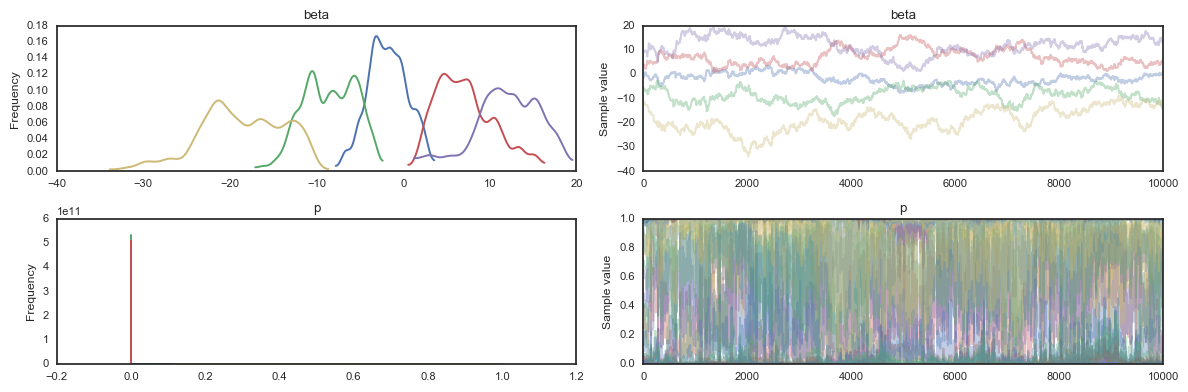

In [7]:
from pymc3 import traceplot
traceplot(iris_trace)

In [8]:
beta_trace = iris_trace['beta']
beta_mean = np.mean(beta_trace,axis = 0)
print('Posterior of beta using mean:',beta_mean)

Posterior of beta using mean: [ -1.80168492  -8.53694924   7.16584228  11.85549027 -18.72320989]


In [9]:
beta_map = find_MAP(model=iris_model)['beta']
#beta_map.beta.values

Optimization terminated successfully.
         Current function value: 22.611224
         Iterations: 34
         Function evaluations: 36
         Gradient evaluations: 36


In [10]:
print('Posterior of beta using MAP:',beta_map)

Posterior of beta using MAP: [ -1.20776057  -5.63262233   4.1287457    8.93324881 -11.13317873]


In [11]:
def check_MLDT(b,x,y):
    p_m = 1./(1.+ np.exp(-np.dot(b,x.T)))
    count = 0
    error = 0
    y_pre = np.zeros(len(y))
    for i in range(len(y)):
        if (p_m[i]>=0.5):
            y_pre[i] = 1
        else:
            y_pre[i] = 0

        if (y_pre[i] == y[i]):
            count += 1

        else:
            error += 1
    return count/(len(y))
        
        


In [12]:
from scipy.stats import bernoulli
def check_bern(b,x,y):
    p_m = 1./(1.+ np.exp(-np.dot(b,x.T)))
    count = 0
    error = 0
    y_pre = np.zeros(len(y))
    for i in range(len(y)):
        y_pre[i] = bernoulli.rvs(p_m[i])

        if (y_pre[i] == y[i]):
            count += 1

        else:
            error += 1
    return count/(len(y))
        

Histogram for each beta component:


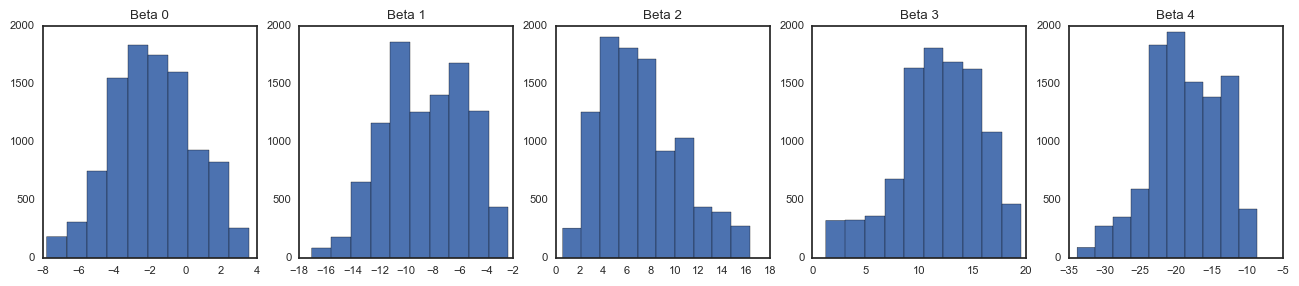

In [13]:
print ('Histogram for each beta component:')
fig, ax = plt.subplots(1, 5, figsize=(16, 3))

for i in range(5):
    ax[i].hist(iris_trace['beta'][:,i])
    ax[i].set_title('Beta %d' % i)

<font color = "red">
### Check with Beta.mean

<font color = "blue">
#### Check using training set and MLDT

In [14]:
print ('Accuracy probability for training set:',check_MLDT(beta_mean,train_x,train_y) )

Accuracy probability for training set: 0.9888888888888889


<font color = "blue">
#### Check using training set and Bernoulli likelihood

In [15]:
print ('Accuracy probability for training set:',check_bern(beta_mean,train_x,train_y) )

Accuracy probability for training set: 0.9555555555555556


<font color = "blue">
#### Check using tesing set and MLDT

In [16]:
print ('Accuracy probability testing set:',check_MLDT(beta_mean,test_x,test_y) )

Accuracy probability testing set: 0.9666666666666667


<font color = "blue">
#### Check using tesing set and Bernoulli likelihood

In [17]:
print ('Accuracy probability for testing set:',check_bern(beta_mean,test_x,test_y) )

Accuracy probability for testing set: 0.9666666666666667


<font color = "red">
### Check with Beta.MAP

<font color = "blue">
#### Check using training set and MLDT

In [18]:
print ('Accuracy probability for training set:',check_MLDT(beta_map,train_x,train_y) )

Accuracy probability for training set: 0.9777777777777777


<font color = "blue">
#### Check using training set and Bernoulli likelihood

In [19]:
print ('Accuracy probability for training set:',check_bern(beta_map,train_x,train_y) )

Accuracy probability for training set: 0.9222222222222223


<font color = "blue">
#### Check using tesing set and MLDT

In [20]:
print ('Accuracy probability testing set:',check_MLDT(beta_map,test_x,test_y) )

Accuracy probability testing set: 0.9666666666666667


<font color = "blue">
#### Check using testing set and Bernoulli likelihood

In [21]:
print ('Accuracy probability testing set:',check_bern(beta_map,test_x,test_y) )

Accuracy probability testing set: 0.9333333333333333


<font color = "blue">
#### Obtain the MAP and MEAN estimate of $\beta$

MAP estimates: [ -1.80168492  -8.53694924   7.16584228  11.85549027 -18.72320989]
MEAN estimates: [ -1.20776057  -5.63262233   4.1287457    8.93324881 -11.13317873]


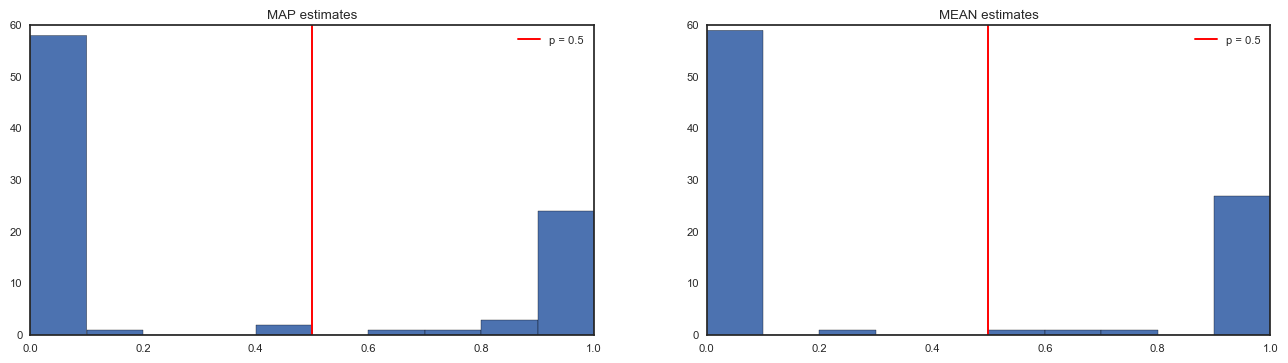

In [22]:
print('MAP estimates:',beta_mean)
#p_beta_mean = 1./(1.+ np.exp(-beta_mean))
print ('MEAN estimates:',beta_map)
#print(beta_trace)
p_trace = np.zeros((beta_trace.shape[0],len(train_x)))
for i in range (beta_trace.shape[0]):
    p_trace[i] = 1./(1.+ np.exp(-np.dot(beta_trace[i],train_x.T)))
    
p_map = 1./(1.+ np.exp(-np.dot(beta_map,train_x.T)))
#print ('P_map',p_map)
p_mean = 1./(1.+ np.exp(-np.dot(beta_mean,train_x.T)))
#print ('P_mean',p_mean)        

fig, axes = plt.subplots(1, 2, figsize=(16,4))
axes = axes.ravel()
axes[0].hist(p_map);
axes[0].set_title("MAP estimates")
axes[0].axvline(x=0.5,color='red', label='p = 0.5')
axes[0].legend(loc='best')
axes[1].hist(p_mean);
axes[1].set_title("MEAN estimates")
axes[1].axvline(x=0.5,color='red', label='p = 0.5')
axes[1].legend(loc='best')  
plt.show()
    

<font color = "blue">
### Choose two points

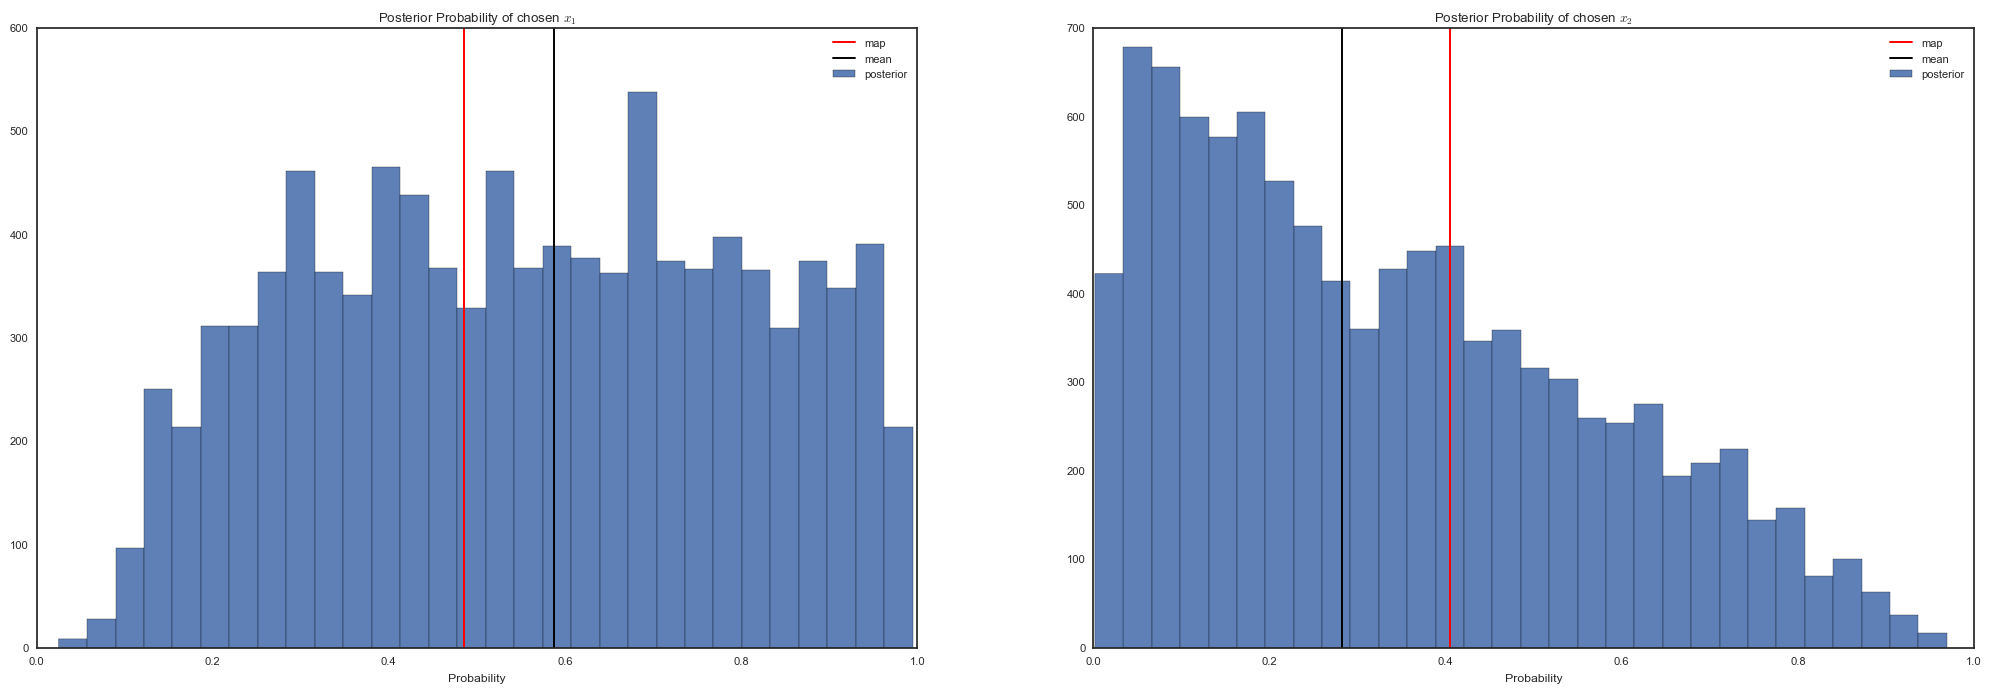

In [23]:
dif_map = []
dif_mean = []
for i in range(len(p_map)):
    point_map = p_map[i]
    point_mean = p_mean[i]
    dif_map.append([i, abs(point_map-0.5)])
    dif_mean.append([i, abs(point_mean-0.5)])
dif_map = sorted(dif_map,key=lambda x: x[1])    
dif_mean = sorted(dif_mean,key=lambda x: x[1])

#choose the top 2 points which are close to 0.5
map_index = [dif_map[0][0], dif_map[1][0]]
mean_index = [dif_mean[0][0], dif_mean[1][0]]


# Plot the probability distribution of the two points

fig = plt.figure(figsize=(25,8))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.set_title('Posterior Probability of chosen $x_1$')
ax1.set_xlabel('Probability')
ax1.hist(p_trace[:,map_index[0]], bins=30, label='posterior',  alpha=0.9)
ax1.axvline(x=p_map[map_index[0]],color='red', label='map')
ax1.axvline(x=p_mean[map_index[0]], color='black', label='mean')
ax1.legend()

ax2.set_title('Posterior Probability of chosen $x_2$')
ax2.set_xlabel('Probability')
ax2.hist(p_trace[:,map_index[1]], bins=30, label='posterior',  alpha=0.9)
ax2.axvline(x=p_map[map_index[1]],color='red', label='map')
ax2.axvline(x=p_mean[map_index[1]], color='black', label='mean')
ax2.legend()

plt.show()

---

Now that we have both point estimate(s) and a posterior distribution on the probability of a data point being virginica, we can use these to make predictions on both the training set and test set.

**There are two ways to make these predictions, given an estimate of $p(y=1 \vert x)$ **: 

(A) You can sample from the Bernoulli likelihood at the data point $x$ to decide if that particular data points classification $y(x)$ should be a 1 or a 0.

(B) Or you could do the intuitive "machine-learning-decision-theoretic" (MLDT) thing, where you assign a data  point $x$ a classification 1 if $p(y=1 \vert x) > 0.5$.

**And there are multiple ways in which you can do these probability estimates at a sample $x$**:

(A) You could just use the MAP value, ($p_{MAP}$), or the posterior mean ($p_{MEAN}$)

(B) You can see what fraction of your posterior samples have values above 0.5 (ie you are calculating 1-cdf(0.5)) on the posterior ($p_{CDF}$))

(C) Both these above methods miss the combined smearing of the posterior and sampling distributions. In other words they dont sample from the posterior predictive. If we draw a large number of samples from the posterior predictive distribution at a data point $x$, the fraction of 1s will give an estimate for the probability to use, $p_{PP}$, which is different from the MAP estimate, or the CDF estimate.

## Part B: Playing with Probabilities

1. Plot the distribution of $p_{MEAN}$, $p_{CDF}$, and $p_{PP}$ over all the data points in the training set. How are these different?
2. Plot the posterior-predictive distribution of the misclassification rate with respect to the true class identities $y(x)$ of the data points $x$ (in other words you are plotting a histogram with the misclassification rate for the $n_{trace}$ posterior-predictive samples) on the training set.
3. Make the same plot from the posterior, rather than the posterior predictive, by using the MLDT defined above. Overlay this plot on the previous one. That is, for every posterior sample, consider whether the data point ought to be classified as a 1 or 0 from the $p>0.5 \implies y=1$ decision theoretic prespective. Compare with your previous diagram. Which case (from posterior-predictive or from-posterior) has a wider mis-classification distribution? 
4. Is the classification at the true training data points (you can think of this as a bitstring '100101...' 90 characters long) represented in the posterior predictive trace? If so, how many times? Is it the most frequent string in the traces? Explain your conclusions.
5. Repeat 2 and 3 for the test set, i.e. make predictions. Describe and interpret the widths of the distributions?
 



In [24]:
p_map = 1./(1.+ np.exp(-np.dot(beta_map,train_x.T)))
print ('P_map',p_map)
p_mean = 1./(1.+ np.exp(-np.dot(beta_mean,train_x.T)))
print ('P_mean',p_mean)      

P_map [  1.61009560e-12   4.73294384e-14   2.46812949e-13   1.19355347e-02
   2.66961394e-02   9.98626755e-01   9.84127907e-01   1.98479575e-02
   9.99682319e-01   9.43950688e-13   9.88218475e-01   9.69364638e-01
   1.80658352e-12   3.05853065e-15   4.04793754e-01   3.87963631e-03
   9.98794726e-01   3.27156696e-14   9.90838172e-01   9.84080278e-01
   2.19386036e-13   4.38582528e-13   1.36796417e-12   7.33301184e-03
   4.85769714e-01   5.23220970e-03   2.44009723e-03   4.00237959e-13
   8.19505585e-01   4.82438466e-03   4.28609904e-04   9.99708429e-01
   9.97248650e-01   3.72458236e-03   8.53457313e-01   2.83518840e-02
   9.63458840e-01   1.28152104e-01   9.99813495e-01   2.02067332e-02
   9.01323558e-01   9.32962780e-01   3.28582963e-12   4.71176401e-10
   5.10054871e-02   6.50268155e-01   9.99999132e-01   1.23499850e-13
   8.60488881e-02   6.90407443e-14   1.77587712e-02   1.46524940e-03
   9.99775412e-01   9.39531600e-03   7.05555652e-12   7.13473984e-01
   2.34487189e-02   9.993963

In [25]:
p_cdf = np.zeros(len(p_map))
for i in range(len(p_map)):
    p_mean_count = 0
    for j in range(p_trace.shape[0]):
        if (p_trace[j,i] > 0.5):
            p_mean_count += 1
    p_cdf[i] =  p_mean_count/p_trace.shape[0]
        
p_cdf

array([ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  1.    ,  1.    ,
        0.    ,  1.    ,  0.    ,  1.    ,  1.    ,  0.    ,  0.    ,
        0.2497,  0.    ,  1.    ,  0.    ,  1.    ,  1.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.5742,  0.    ,  0.    ,  0.    ,
        0.9647,  0.    ,  0.    ,  1.    ,  0.9995,  0.    ,  0.9956,
        0.    ,  0.9998,  0.0895,  1.    ,  0.    ,  0.9957,  0.9756,
        0.    ,  0.    ,  0.    ,  0.7079,  1.    ,  0.    ,  0.0036,
        0.    ,  0.    ,  0.    ,  1.    ,  0.    ,  0.    ,  0.876 ,
        0.    ,  1.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  1.    ,  1.    ,  1.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  1.    ,  0.    ,  0.    ,
        0.    ,  0.001 ,  0.    ,  1.    ,  0.    ,  1.    ,  0.    ,
        1.    ,  0.    ,  0.    ,  0.    ,  0.9587,  0.    ])

In [26]:
p_p = np.zeros(len(train_x))
ber = np.zeros((p_trace.shape[0],len(p_p)))

for i in range(len(p_p)):
    for j in range(p_trace.shape[0]):
        ber[j,i] = bernoulli.rvs(p_trace[j,i])

for i in range(len(p_p)):
    ber_count = 0
    for j in range(p_trace.shape[0]):
        if (ber[j,i]==1):
            ber_count += 1
    p_p[i] =  ber_count/p_trace.shape[0]    
            

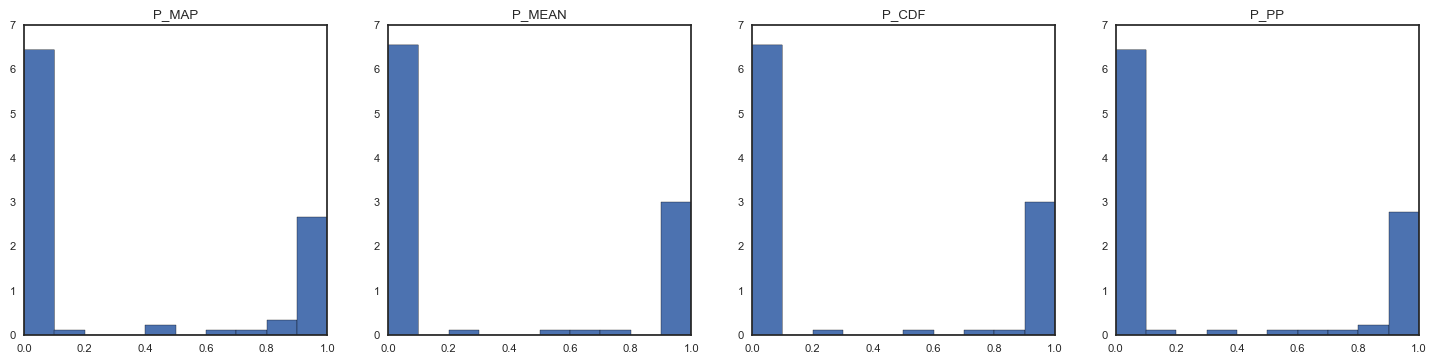

In [27]:
fig, ax = plt.subplots(1, 4, figsize=(18, 4))

ax[0].hist(p_map, normed=True)
ax[0].set_title('P_MAP')

ax[1].hist(p_mean, normed=True)
ax[1].set_title('P_MEAN')

ax[2].hist(p_cdf, normed=True)
ax[2].set_title('P_CDF')

ax[3].hist(p_p, normed=True)
ax[3].set_title('P_PP')
plt.show()

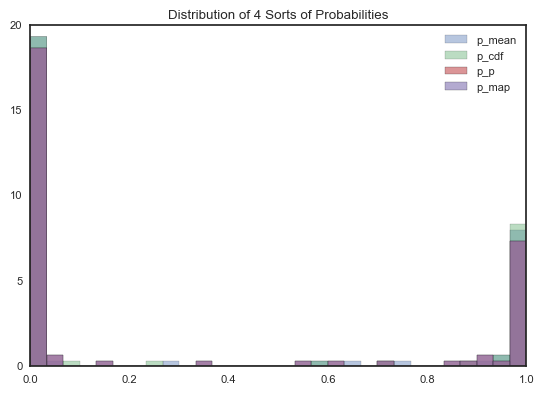

In [46]:
plt.hist(p_mean,bins=30, alpha=0.4, label=u'p_mean', normed=True)
plt.hist(p_cdf,bins=30, alpha=0.4,label=u'p_cdf', normed=True)
plt.hist(p_p,bins=30, alpha=0.6,label=u'p_p', normed=True)
plt.hist(p_p,bins=30, alpha=0.6,label=u'p_map', normed=True)
plt.legend()

plt.title('Distribution of 4 Sorts of Probabilities')
plt.show()

<font color = "blue">
### Summary
posterior-predictive has a wider mis-classification distribution

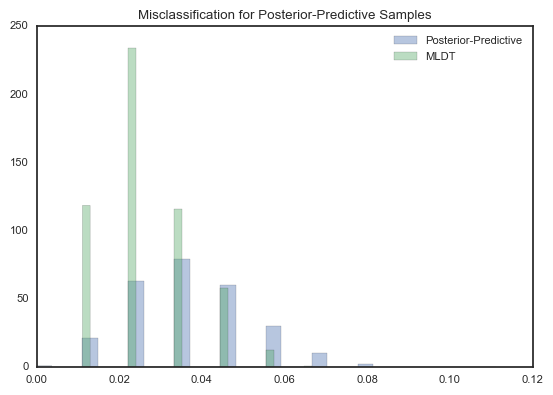

In [29]:
mis_pp = np.zeros(ber.shape[0])
for i in range(ber.shape[0]):
    mis_pp[i] = np.mean(abs(ber[i] - train_y))
plt.hist(mis_pp,bins=30, alpha=0.4,label=u'Posterior-Predictive', normed=True)
plt.title('Misclassification for Posterior-Predictive Samples')

mis_post = np.zeros(ber.shape[0])
result = np.zeros((p_trace.shape[0],len(p_p)))
for i in range(p_trace.shape[0]):
    for j in range(p_trace.shape[1]):
        if (p_trace[i,j] > 0.5):
            result[i,j] = 1
        else:
            result[i,j] = 0

for i in range(p_trace.shape[0]):
    mis_post[i] = np.mean(abs(result[i] - train_y))
plt.hist(mis_post,bins=30, alpha=0.4,label=u'MLDT', normed=True)
plt.legend()
plt.show()

In [30]:
ber.shape

(10000, 90)

<font color = "blue">
### Summary
posterior-predictive has a wider mis-classification distribution

In [31]:
con = {}
for i in range(ber.shape[0]):
    arr = ''.join(list(ber[i,:].astype(int).astype(str)))
    if arr in con:
        con[arr] += 1
    else:
        con[arr] = 1
        
arr_true = ''.join(list(train_y.astype(int).astype(str)))
print ('The true sequence:',arr_true)
print ('The number of times for the correct prediction is:',con[arr_true])



The true sequence: 000001101011000010110000100010011000101011000110000010010100000011100000001000001010100010
The number of times for the correct prediction is: 38


In [32]:
sorted_arr = sorted(con.items(), key=operator.itemgetter(1))
print ('The most frequent sequence:',sorted_arr[-1][0])
print ('The number of times for the most frequent sequenct is:',sorted_arr[-1][1])

The most frequent sequence: 000001101011000010110000100010011010101011000110000010010100000011100000001000001010100010
The number of times for the most frequent sequenct is: 666


In [33]:
sorted_arr[-1], sorted_arr[-2], sorted_arr[-3], sorted_arr[-4]

(('000001101011000010110000100010011010101011000110000010010100000011100000001000001010100010',
  666),
 ('000001101011001010110000100010011010101011000110000010010100000011100000001000001010100010',
  498),
 ('000001101011000010110000000010011010101011000110000010010100000011100000001000001010100010',
  427),
 ('000001101011000010110000100010011010101011000010000010010100000011100000001000001010100010',
  420))

<font color = "blue">
### Summary
The true predictive sequence is not the most frequent string in the traces.

<font color = "red">

### For testing data

In [34]:
p_trace_test = np.zeros((beta_trace.shape[0],len(test_x)))
for i in range (beta_trace.shape[0]):
    p_trace_test[i,:] = 1./(1.+ np.exp(-np.dot(beta_trace[i],test_x.T)))
    

In [35]:
p_p_test = np.zeros(len(test_x))
ber_test = np.zeros((p_trace_test.shape[0],p_trace_test.shape[1]))

for i in range(p_trace_test.shape[1]):
    ber_t_count = 0
    for j in range(p_trace_test.shape[0]):
        ber_test[j,i] = bernoulli.rvs(p_trace_test[j,i])
        if (ber_test[j,i]==1):
            ber_t_count += 1
    p_p_test[i] =  ber_t_count/p_trace_test.shape[0] 


In [36]:
p_cdf_test = np.zeros(len(test_x))
for i in range(len(test_x)):
    p_mean_count = 0
    for j in range(p_trace_test.shape[0]):
        if (p_trace_test[j,i] > 0.5):
            p_mean_count += 1
    p_cdf_test[i] =  p_mean_count/p_trace_test.shape[0]
        

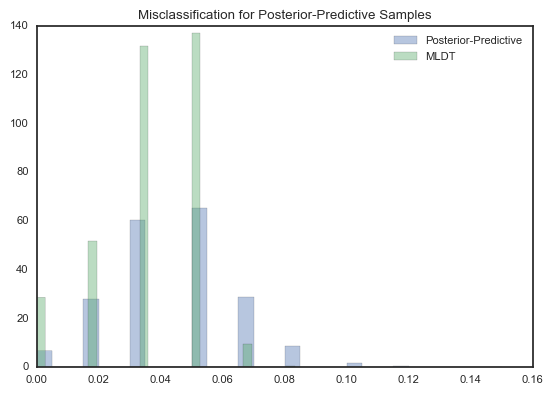

In [37]:
mis_pp_test = np.zeros(ber_test.shape[0])
for i in range(ber_test.shape[0]):
    mis_pp_test[i] = np.mean(abs(ber_test[i] - test_y))
plt.hist(mis_pp_test,bins=30, alpha=0.4,label=u'Posterior-Predictive', normed=True)
plt.title('Misclassification for Posterior-Predictive Samples')

mis_post_test = np.zeros(ber_test.shape[0])
result_test = np.zeros((p_trace_test.shape[0],p_trace_test.shape[1]))
for i in range(p_trace_test.shape[0]):
    for j in range(p_trace_test.shape[1]):
        if (p_trace_test[i,j] > 0.5):
            result_test[i,j] = 1
        else:
            result_test[i,j] = 0

for i in range(ber_test.shape[0]):
    mis_post_test[i] = np.mean(abs(result_test[i] - test_y))
plt.hist(mis_post_test,bins=30, alpha=0.4,label=u'MLDT', normed=True)
plt.legend()
plt.show()


<font color = 'blue'>
### Summary
As shown above, compared with training dataset, the distributions are wider for testing dataset (i.e.the performance of our model fitting testing set is relatively low) because the model is derived from training set. On the other hand, the width of two distribution of MLDT and Posterior Predictive is close, but using MLDT causes higher-weighted error rate than posterior predictive.

## Extra Credit: Deriving the MLDT

If you took a distribution of prediction to your boss, he/she would probably ask you to make a choice. Decision Theory is the right way to make such a choice, rather than choosing an arbitrary set of bernoulli samplings. The idea is to minimize the posterior predictive averaged decision risk at each sample $x$:

$$R(g, x) = \int dy P(y \vert x) R(g, y \vert x) = \sum_{y=0,1} P(y \vert x) R(g, y \vert x)$$

where $g$ is the action you take: classify as 1 or 0. Use $R(g, y \vert x) = {\mathbb 1}_{g \ne y} \forall x$, the 1-0 loss.

1. Show that if $R(1, x) <= R(0, x)$ and thus we choose 1 as our classification, $p(1 \vert x) >= 0.5$. 
2. Use this MLDT rule and probabilities from both $p_{CDF}$ and $p_{PP}$ to make two classifications on the training set and test set. What is the misclassification rate in both? WHy do you think this is the case? 

<font color = "blue">
Proof:
$$R(g, x) = \int dy P(y \vert x) R(g, y \vert x) = \sum_{y=0,1} P(y \vert x) R(g, y \vert x)$$
$$R(0, x) =  P(1 \vert x)  R(0, 1 \vert x) + P(0 \vert x)  R(0, 0 \vert x) = P(1 \vert x) $$
$$R(1, x) =  P(1 \vert x)  R(1, 1 \vert x) + P(0 \vert x)  R(1, 0 \vert x) = P(0 \vert x) $$

If $R(1, x) <= R(0, x)$,   
$$ P(0 \vert x) = 1 - P(1 \vert x) <= P(1 \vert x) $$
Therefore, $$p(1 \vert x) >= 0.5  $$

In [38]:
def compare(y,p):
    result = np.zeros(y.shape[0])
    c = 0
    for i in range(y.shape[0]):
        if (p[i] > 0.5):
            result[i] = 1

        else:
            result[i] = 0

        if (result[i] != y[i]):
            c += 1
    return c/y.shape[0]

In [39]:
mis_rate_pp_train = compare(train_y,p_p)
print ('Training: misclassification rate from p_pp:',mis_rate_pp_train)

Training: misclassification rate from p_pp: 0.011111111111111112


In [40]:
mis_rate_cdf_train = compare(train_y,p_cdf)
print ('Training: misclassification rate from p_cdf:',mis_rate_cdf_train)

Training: misclassification rate from p_cdf: 0.011111111111111112


In [41]:
mis_rate_pp_test = compare(test_y,p_p_test)
print ('Testing: misclassification rate from p_pp:',mis_rate_pp_test)

Testing: misclassification rate from p_pp: 0.03333333333333333


In [42]:
mis_rate_cdf_test = compare(test_y,p_p_test)
print ('Testing: misclassification rate from p_cdf:',mis_rate_cdf_test)

Testing: misclassification rate from p_cdf: 0.03333333333333333
